# Testing out the variance subtraction method

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest
from astropy.table import vstack

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


In [2]:
def get_stacked_sets(snapshots):
    inners = []
    outers = []
    for hvc_snap in snapshots:
        inner_rms, outer_rms = KStest.split_RMs(hvc_snap["RMs"],hvc_snap["HVC"]["SkyCoord"], KStest.morph_ring(hvc_snap))
        inners.append(inner_rms)
        outers.append(outer_rms)

    master_rm_inner = vstack(inners)
    master_rm_outer = vstack(outers)

    return master_rm_inner, master_rm_outer, inners, outers

master_rm_inner, master_rm_outer, inners, outers = get_stacked_sets(master_hvcs)

[]

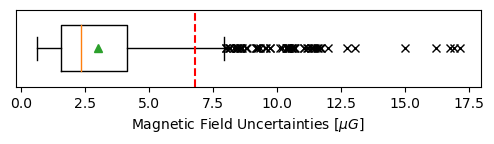

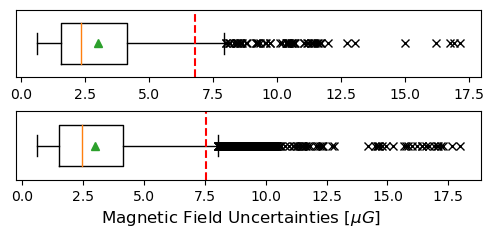

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def uncertainty_boxplot(master_rm, single=False, limit=20):
    rms = master_rm["B_virtual_unc [int]"].data * 1e6
    B_unc = rms[rms < 20]
    B_true_unc = np.std(master_rm["B_virtual [int]"].data * 1e6)

    if single:
        plt.figure(figsize=(6,1))
        plt.boxplot(B_unc, vert=False, showmeans=True, widths=0.6, sym="x")
        plt.axvline(B_true_unc, c='r', linestyle='--')
        plt.yticks([])
        plt.xlabel(r"Magnetic Field Uncertainties [$\mu G$]")
    else:
        plt.boxplot(B_unc, vert=False, showmeans=True, widths=0.6, sym="x")
        plt.axvline(B_true_unc, c='r', linestyle='--')
        plt.yticks([])

def uncertainty_boxplots(master_rm_inner, master_rm_outer):
    fig = plt.figure(figsize=(6,2.5))
    
    fig.supxlabel(r"Magnetic Field Uncertainties [$\mu G$]")

    plt.tight_layout()

    plt.subplot(2, 1, 1)
    uncertainty_boxplot(master_rm_inner)
    plt.subplot(2, 1, 2)
    uncertainty_boxplot(master_rm_outer)
    plt.subplots_adjust(hspace=0.5, bottom=0.2)

uncertainty_boxplot(master_rm_inner, True)
plt.plot()
uncertainty_boxplots(master_rm_inner, master_rm_outer)
plt.plot()

In [4]:
from astropy.table import Table, hstack, Column
import copy

def uncertainty_table(table_list):
    uncert = []
    for rms in table_list:
        m_list = rms["B_virtual_unc [int]"].data * 1e6
        o_list = rms["B_virtual [int]"].data * 1e6

        meas = np.mean(m_list)
        obsv = np.std(o_list)

        uncert.append({"Sigma [meas]":meas, "Sigma [obsv]":obsv, "Sigma [true]": np.sqrt(obsv**2 - meas**2)})

    uncert_table = Table(uncert)

    return uncert_table

def uncertainty_subtract(inners, outers):
    inner_sigma = uncertainty_table(inners)
    outer_sigma = uncertainty_table(outers)

    sub = inner_sigma["Sigma [true]"]-outer_sigma["Sigma [true]"]
    fwhm = 2 * np.sqrt(2 * np.log(2)) * np.array(sub)

    fwhm_table = copy.deepcopy(inner_sigma)

    fwhm_table.add_column(sub, name="Sigma [diff]")
    fwhm_table.add_column(fwhm, name="FWHM")

    return fwhm_table, inner_sigma, outer_sigma

fwhm_table, inner_sigma, outer_sigma = uncertainty_subtract(inners, outers)

fwhm_table

C:\Users\olive\AppData\Local\Temp\ipykernel_16016\1208703601.py:13: RuntimeWarning: invalid value encountered in sqrt
  uncert.append({"Sigma [meas]":meas, "Sigma [obsv]":obsv, "Sigma [true]": np.sqrt(obsv**2 - meas**2)})


Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
float64,float64,float64,float64,float64
1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
1.7766805216998156,6.285240753776755,6.028901861595415,4.354124583319416,10.253179847362592
1.390653120203451,0.6443423969361269,nan,nan,nan
2.5577313774843344,3.3456971641453612,2.1567799412092095,-0.4370240961740395,-1.0291131018321615
8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079


In [14]:
def uncertainty_readwrite(uncert_table, filter_significant=False, load_file="../data_processed/hvc_KS_tests/hvc_KS_average", save_file="../data_processed/results_pre"):
    ks = ct.read_processed(load_file)
    hks = hstack([ks, uncert_table])

    if filter_significant:
        hks = hks[hks["Significant"]]
        hks = hks[~np.isnan(hks["Sigma [diff]"])]

    ct.write_processed(hks, save_file)

    return hks

results = uncertainty_readwrite(fwhm_table)
results_filtered = uncertainty_readwrite(fwhm_table, save_file="../data_processed/results_filtered", filter_significant=True)

In [15]:
results_filtered

Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,2.5503785393572116,True,1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,1.245611675868496,True,1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,2.2846397376409495,True,1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,7.064597943499491,True,8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,5.008552948039634,True,5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,-2.1167595348071426,True,3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079
G267.1-38.4+263,0.3428488020518381,2.318648482161409e-11,12.715164074377505,-1,9.411860771074203,True,6.459354538810761,13.975229335809928,12.392892072895142,3.764226145036,8.86407518036035
G271.6-48.4+297,0.12493061782161308,5.0905622111774864e-05,0.6348560731135152,-1,0.5747960130534552,True,1.656313599761247,3.0167700520864895,2.5214136523807156,0.14031802939919347,0.33042370830846285
G271.7-53.1+254,0.22697520500279825,0.0003403465863955054,0.11625707523884121,1,-2.3862454272636606,True,3.238101358605643,6.206104031068475,5.294376907232867,-0.6047436349837891,-1.4240624337647063


In [16]:
results

Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,2.5503785393572116,True,1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,1.245611675868496,True,1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,2.2846397376409495,True,1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,-2.4420848538134305,False,1.7766805216998156,6.285240753776755,6.028901861595415,4.354124583319416,10.253179847362592
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,1.7746068755102902,True,1.390653120203451,0.6443423969361269,nan,nan,nan
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-2.5040967925547646,-1,0.5189262304682574,False,2.5577313774843344,3.3456971641453612,2.1567799412092095,-0.4370240961740395,-1.0291131018321615
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,7.064597943499491,True,8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,5.008552948039634,True,5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,-2.1167595348071426,True,3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079


# Putting it all together

In [2]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest, uncertainty_subtraction as us

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

#master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

results = hvcl.uncertainty_subtract_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24], save_file="", filter_significant=True)

results

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


C:\/Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project\synthesis.py:360: RuntimeWarning: invalid value encountered in sqrt
  uncert.append({"Sigma [meas]":meas, "Sigma [obsv]":obsv, "Sigma [true]": np.sqrt(obsv**2 - meas**2)})


Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,2.5503785393572116,True,1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,1.245611675868496,True,1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,2.2846397376409495,True,1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,7.064597943499491,True,8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,5.008552948039634,True,5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,-2.1167595348071426,True,3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079
G267.1-38.4+263,0.3428488020518381,2.318648482161409e-11,12.715164074377505,-1,9.411860771074203,True,6.459354538810761,13.975229335809928,12.392892072895142,3.764226145036,8.86407518036035
G271.6-48.4+297,0.12493061782161308,5.0905622111774864e-05,0.6348560731135152,-1,0.5747960130534552,True,1.656313599761247,3.0167700520864895,2.5214136523807156,0.14031802939919347,0.33042370830846285
G271.7-53.1+254,0.22697520500279825,0.0003403465863955054,0.11625707523884121,1,-2.3862454272636606,True,3.238101358605643,6.206104031068475,5.294376907232867,-0.6047436349837891,-1.4240624337647063


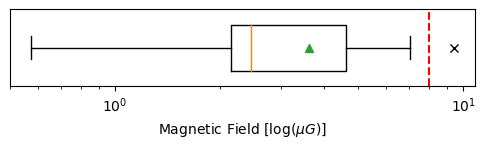

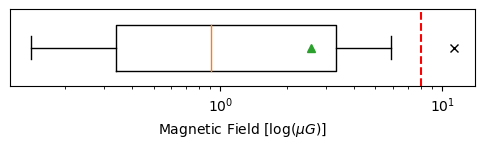

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.boxplot(abs(results["Statistic_diff"]), vert=False, showmeans=True, widths=0.6, sym="x")
plt.yticks([])
plt.axvline(8, c='r', linestyle='--')
plt.xlabel(r"Magnetic Field [log($\mu G$)]")
plt.xscale('log')
plt.show()

plt.figure(figsize=(6,1))
plt.boxplot(abs(results["Sigma [diff]"]), vert=False, showmeans=True, widths=0.6, sym="x")
plt.yticks([])
plt.axvline(8, c='r', linestyle='--')
plt.xlabel(r"Magnetic Field [log($\mu G$)]")
plt.xscale('log')
plt.show()